In [1]:
import pandas as pd

In [4]:
dataset_path = "C:/Users/stuti/Documents/CS410/Comparative-sentiment-analysis/IMDBDataset.csv"
dataset = pd.read_csv(dataset_path)
# rename the Column names to Text and Sentiment
dataset.columns = ['Text', 'Sentiment']
# remove the rows with missing values
dataset = dataset.dropna()


dataset.head()

,Text,Sentiment
0,One of the other reviewers has mentioned that ...,positive
1,A wonderful little production. <br /><br />The...,positive
2,I thought this was a wonderful way to spend ti...,positive
3,Basically there's a family where a little boy ...,negative
4,"Petter Mattei's ""Love in the Time of Money"" is...",positive


## Process the text

In [5]:
import pandas as pd
import requests
from io import StringIO
from nltk.corpus import stopwords
import nltk
nltk.download('stopwords')
import string
from collections import Counter
import tqdm
import re
nltk.download('punkt')
from nltk.tokenize import word_tokenize
import numpy as np
from sklearn.metrics.pairwise import cosine_similarity
from nltk.stem import PorterStemmer as ps
def process_text(text):
     # transform to lower case
    text = text.lower()
    # get the sentence with the most number of words
    # Remove punctuation and numbers
    text = re.sub(r'[^a-z\s]', '', text)
    # Remove excess white spaces from the text and get words list
    words_list = word_tokenize(text)
    # Remove stopwords
    stop_words = stopwords.words('english')
    words_list = [word for word in words_list if word not in stop_words]
    # join words seperated by whitespace
    modified_text = ' '.join(words_list)
    return modified_text, words_list

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\stuti\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!
[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\stuti\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


In [6]:
# retain only 1000 random rows from the dataset
dataset = dataset.sample(1000)
# reset the index
dataset = dataset.reset_index(drop=True)
dataset.head()

,Text,Sentiment
0,I think it definitely is. The writing is of su...,positive
1,"So, I'm wondering while watching this film, di...",negative
2,"Just imagine the real Hitler, who was a master...",negative
3,I have no idea as to which audience director G...,negative
4,One of the last films DIRECTED by Lionel Barry...,positive


In [7]:
# for each review, process the text
for i in range(len(dataset)):
    dataset['Text'][i], words_list = process_text(dataset['Text'][i])

In [8]:
print(len(dataset))
true_sentiments = dataset['Sentiment'].values 

1000


## Transformers sentiment analysis and evaluation

In [9]:
!pip install torch


In [10]:

import time
from sklearn.metrics import precision_recall_fscore_support
import numpy as np
from transformers import pipeline
nlp = pipeline("sentiment-analysis")


No model was supplied, defaulted to distilbert-base-uncased-finetuned-sst-2-english (https://huggingface.co/distilbert-base-uncased-finetuned-sst-2-english)
Downloading: 100%|██████████| 629/629 [00:00<00:00, 522kB/s]
Downloading: 100%|██████████| 268M/268M [00:11<00:00, 22.7MB/s] 
Downloading: 100%|██████████| 48.0/48.0 [00:00<00:00, 27.2kB/s]
Downloading: 100%|██████████| 232k/232k [00:00<00:00, 10.8MB/s]


In [18]:
# Example function to analyze sentiment
def analyze_sentiment_transformers(text):
    start_time = time.time()
    response = nlp(text)
    end_time = time.time()
    response_time = end_time - start_time
    sentiment = response[0]['label'] = response[0]['label'].lower()
    confidence = response[0]['score']
    return sentiment, confidence, response_time


In [20]:
results = []
predicted_labels_transformers = []

for true_sentiment, text in zip(true_sentiments, dataset['Text'].tolist()):
    # openai_sentiment, openai_time = analyze_sentiment_openai(text)
    try:
        transformers_sentiment, transformers_confidence, transformers_time = analyze_sentiment_transformers(text)
    except Exception as e:
        transformers_sentiment, transformers_confidence, transformers_time = "neutral", 0, 0
    
    results.append({
        "Text": text,
        "True Sentiment": true_sentiment,
        # "OpenAI Sentiment": openai_sentiment,
        # "OpenAI Response Time (s)": openai_time,
        "transformers Sentiment": transformers_sentiment,
        "transformers Confidence": transformers_confidence,
        "transformers Response Time (s)": transformers_time
    })
    
    # predicted_labels_openai.append(openai_sentiment)
    predicted_labels_transformers.append(transformers_sentiment)

# Convert results to DataFrame for easier analysis and display
results_df = pd.DataFrame(results)
results_df.to_csv("results_transformers.csv", index=False)

[{'label': 'NEGATIVE', 'score': 0.9933918118476868}]
[{'label': 'NEGATIVE', 'score': 0.9982566237449646}]
[{'label': 'NEGATIVE', 'score': 0.9976457953453064}]
[{'label': 'NEGATIVE', 'score': 0.9959321618080139}]
[{'label': 'POSITIVE', 'score': 0.7258853316307068}]
[{'label': 'POSITIVE', 'score': 0.9986656904220581}]
[{'label': 'NEGATIVE', 'score': 0.9992114305496216}]
[{'label': 'NEGATIVE', 'score': 0.9838878512382507}]
[{'label': 'NEGATIVE', 'score': 0.9579925537109375}]
[{'label': 'POSITIVE', 'score': 0.9970261454582214}]
[{'label': 'NEGATIVE', 'score': 0.998377799987793}]
[{'label': 'NEGATIVE', 'score': 0.9957923889160156}]
[{'label': 'NEGATIVE', 'score': 0.9989689588546753}]
[{'label': 'NEGATIVE', 'score': 0.9987536668777466}]
[{'label': 'NEGATIVE', 'score': 0.9791926145553589}]
[{'label': 'NEGATIVE', 'score': 0.995011568069458}]
[{'label': 'POSITIVE', 'score': 0.9372243881225586}]
[{'label': 'NEGATIVE', 'score': 0.6343148946762085}]
[{'label': 'NEGATIVE', 'score': 0.99889647960662

In [40]:
import json
def calculate_metrics(true_sentiments, predicted_labels, output_file_path, results_df):

    metrics_transformers = precision_recall_fscore_support(true_sentiments, predicted_labels, average='weighted')
    F1_score_transformers = 2/(1/metrics_transformers[0] + 1/metrics_transformers[1])

    # Print metrics
    print("transformers Precision:", metrics_transformers[0])
    print("transformers Recall:", metrics_transformers[1])
    print("transformers F1-Score:", F1_score_transformers)

    # average response time
    average_response_time_transformers = results_df['transformers Response Time (s)'].mean()
    print("Average Response Time:", average_response_time_transformers)
    metrics = {
        "transformers Precision": metrics_transformers[0],
        "transformers Recall": metrics_transformers[1],
        "transformers F1-Score": F1_score_transformers,
        "Average Response Time": average_response_time_transformers,
    }
    with open(output_file_path, "w") as f:
        json.dump(metrics, f)




In [22]:
import matplotlib.pyplot as plt
import seaborn as sns
import numpy as np
def plot(results_df):
    confidence_scores = results_df['transformers Confidence'].values
    plt.figure(figsize=(10, 6))
    sns.histplot(confidence_scores, bins=30, kde=True)
    plt.title('Distribution of Confidence Scores for Adversarial Examples')
    plt.xlabel('Confidence Score')
    plt.ylabel('Frequency')
    plt.show()


In [26]:
for i, label in enumerate(predicted_labels_transformers):
    if label == None:
        predicted_labels_transformers[i] = "neutral"
calculate_metrics(true_sentiments, predicted_labels_transformers, "metrics_tranformers.json")

transformers Precision: 0.8318217549786628
transformers Recall: 0.785
transformers F1-Score: 0.8077329187927308
Average Response Time: 0.3020522072758899


c:\Users\stuti\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


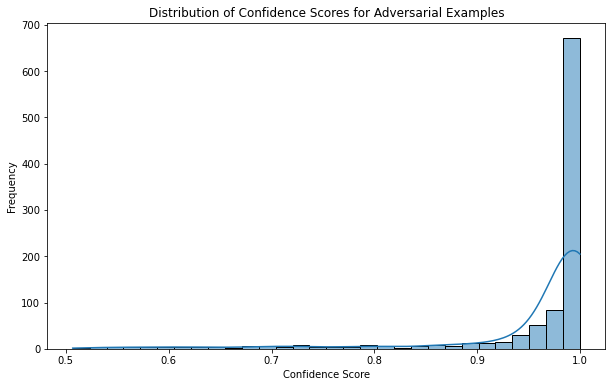

In [27]:
plot(results_df)

## Adversial testing


In [28]:
import random
from nltk.corpus import wordnet

# Ensure nltk resources are available
import nltk
nltk.download('wordnet')
nltk.download('omw-1.4')

# Function to create a simple adversarial example by replacing words with their synonyms
def synonym_replacement(text, n=1):
    words = text.split()
    n = len(words) // 3
    new_words = words.copy()
    random_word_list = list(set([word for word in words if wordnet.synsets(word)]))
    random.shuffle(random_word_list)
    num_replaced = 0
    
    for random_word in random_word_list:
        synonyms = set()
        for syn in wordnet.synsets(random_word):
            for lemma in syn.lemmas():
                synonyms.add(lemma.name())
        if len(synonyms) > 1:
            synonyms.discard(random_word)
            synonym = random.choice(list(synonyms))
            new_words = [synonym if word == random_word else word for word in new_words]
            num_replaced += 1
            if num_replaced >= n: # Only replace up to n words
                break
    
    sentence = ' '.join(new_words)
    return sentence

# Select a few texts randomly and create their adversarial examples
sample_texts = dataset['Text']
adversarial_examples = [synonym_replacement(text) for text in sample_texts]

def remove_random_spaces(text, n=1):
    words = text.split()
    n = len(words) // 10
    new_words = words.copy()
    num_removed = 0
    
    for i in range(n):
        random_index = random.randint(0, len(new_words)-1)
        new_words.pop(random_index)
    
    sentence = ' '.join(new_words)
    return sentence

adversarial_examples = [remove_random_spaces(text) for text in sample_texts]


[nltk_data] Downloading package wordnet to
[nltk_data]     C:\Users\stuti\AppData\Roaming\nltk_data...
[nltk_data]   Package wordnet is already up-to-date!
[nltk_data] Downloading package omw-1.4 to
[nltk_data]     C:\Users\stuti\AppData\Roaming\nltk_data...
[nltk_data]   Package omw-1.4 is already up-to-date!


In [29]:
print(adversarial_examples)

['think definitely quality beginner students english language model dialogue example exchange kerseybronson ms kathryn davisdeborah raffin character later extremely clear point ms says hope like chicken thing know kersey deftly responds chickens good like chicken thats english grammar dont know isbr br another ms character kersey sleeps second date practically throws tells wants see one last timethis fourth time theyve ever met sisters house binghamtonny get away creeps really doesnt even bat eye corpse burning minutes later kersey never even says first entirety film never get katy nice dress wearing kathryn careful katie creepsll get yabr br love two oherlihy everwatchful eyes almost kersey bait get fraker much uses camera car sure enough fraker bites kersey bites back hardin incredible sequence events ever caught film final fifteen minutes possibly rivaled final thirty minutes delta force brilliance thats giving force lot credit film see ed lauter take alex order charles bronsons bac

In [31]:
results_adversial = []
predicted_labels_transformers_adversial = []

for true_sentiment, text in zip(true_sentiments, adversarial_examples):
    # openai_sentiment, openai_time = analyze_sentiment_openai(text)
    try:
        transformers_sentiment, transformers_confidence, transformers_time = analyze_sentiment_transformers(text)
    except Exception as e:
        transformers_sentiment, transformers_confidence, transformers_time = "neutral", 0, 0
    
    results_adversial.append({
        "Text": text,
        "True Sentiment": true_sentiment,
        # "OpenAI Sentiment": openai_sentiment,
        # "OpenAI Response Time (s)": openai_time,
        "transformers Sentiment": transformers_sentiment,
        "transformers Confidence": transformers_confidence,
        "transformers Response Time (s)": transformers_time
    })
    
    # predicted_labels_openai.append(openai_sentiment)
    predicted_labels_transformers_adversial.append(transformers_sentiment)

# Convert results to DataFrame for easier analysis and display
results_df_adversial = pd.DataFrame(results_adversial)
results_df_adversial.to_csv("results_transformers_adversial.csv", index=False)

[{'label': 'NEGATIVE', 'score': 0.9861761927604675}]
[{'label': 'NEGATIVE', 'score': 0.9988455772399902}]
[{'label': 'NEGATIVE', 'score': 0.9985059499740601}]
[{'label': 'NEGATIVE', 'score': 0.9910680651664734}]
[{'label': 'POSITIVE', 'score': 0.9951417446136475}]
[{'label': 'POSITIVE', 'score': 0.999173104763031}]
[{'label': 'NEGATIVE', 'score': 0.9993416666984558}]
[{'label': 'NEGATIVE', 'score': 0.9883153438568115}]
[{'label': 'NEGATIVE', 'score': 0.8523471355438232}]
[{'label': 'POSITIVE', 'score': 0.9927549958229065}]
[{'label': 'NEGATIVE', 'score': 0.9980453252792358}]
[{'label': 'NEGATIVE', 'score': 0.997333288192749}]
[{'label': 'NEGATIVE', 'score': 0.999135434627533}]
[{'label': 'NEGATIVE', 'score': 0.997860848903656}]
[{'label': 'NEGATIVE', 'score': 0.9632980227470398}]
[{'label': 'NEGATIVE', 'score': 0.9968417882919312}]
[{'label': 'NEGATIVE', 'score': 0.9724081158638}]
[{'label': 'NEGATIVE', 'score': 0.9243645071983337}]
[{'label': 'NEGATIVE', 'score': 0.9980301260948181}]


In [32]:
calculate_metrics(true_sentiments, predicted_labels_transformers_adversial, "metrics_transformers_adversial30.json")

transformers Precision: 0.8049637863385054
transformers Recall: 0.76
transformers F1-Score: 0.7818359542345809
Average Response Time: 0.3020522072758899


c:\Users\stuti\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


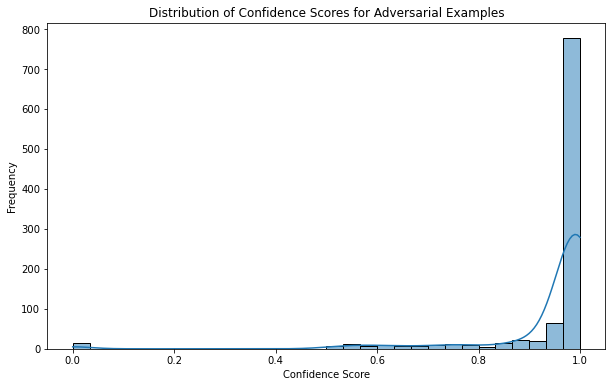

In [33]:
plot(results_df_adversial)

In [37]:
dataset_translated = pd.read_csv("results_openai_lang.csv")
#drop last 2 columns OpenAI Sentiment OpenAI Response Time (s)
dataset_translated = dataset_translated.drop(columns=['OpenAI Sentiment', 'OpenAI Response Time (s)'])
# rename the Column names to Text and Sentiment
dataset_translated.columns = ['Text', 'Sentiment']
dataset_translated.head()

,Text,Sentiment
0,Recientemente me he obsesionado anticipando la...,negative
1,creer atrocidad manejado capturar corazones me...,negative
2,títeres atrás más divertido nunca sin novia no...,positive
3,"Maldita sea, muchos se quedaron bastante hipno...",positive
4,parece importar ver christina ricci parece com...,negative


In [38]:
results_lang = []
predicted_labels_transformers_lang = []

for true_sentiment, text in zip(true_sentiments, dataset_translated['Text'].tolist()):
    # openai_sentiment, openai_time = analyze_sentiment_openai(text)
    try:
        transformers_sentiment, transformers_confidence, transformers_time = analyze_sentiment_transformers(text)
    except:
        transformers_sentiment, transformers_confidence, transformers_time = 'neutral', 0, 0
    results_lang.append({
        "Text": text,
        "True Sentiment": true_sentiment,
        # "OpenAI Sentiment": openai_sentiment,
        # "OpenAI Response Time (s)": openai_time,
        "transformers Sentiment": transformers_sentiment,
        "transformers Confidence": transformers_confidence,
        "transformers Response Time (s)": transformers_time
    })
    
    # predicted_labels_openai.append(openai_sentiment)
    predicted_labels_transformers_lang.append(transformers_sentiment)

# Convert results to DataFrame for easier analysis and display
results_df_lang = pd.DataFrame(results)
results_df_lang.to_csv("results_transformers_lang.csv", index=False)

[{'label': 'NEGATIVE', 'score': 0.9866276383399963}]
[{'label': 'NEGATIVE', 'score': 0.992870032787323}]
[{'label': 'NEGATIVE', 'score': 0.9628230929374695}]
[{'label': 'NEGATIVE', 'score': 0.9897715449333191}]
[{'label': 'NEGATIVE', 'score': 0.988079845905304}]
[{'label': 'NEGATIVE', 'score': 0.9816828966140747}]
[{'label': 'NEGATIVE', 'score': 0.9888491630554199}]
[{'label': 'NEGATIVE', 'score': 0.928807258605957}]
[{'label': 'NEGATIVE', 'score': 0.976524829864502}]
[{'label': 'NEGATIVE', 'score': 0.99054354429245}]
[{'label': 'NEGATIVE', 'score': 0.9948262572288513}]
[{'label': 'NEGATIVE', 'score': 0.9904096126556396}]
[{'label': 'NEGATIVE', 'score': 0.9570502638816833}]
[{'label': 'NEGATIVE', 'score': 0.9883472323417664}]
[{'label': 'NEGATIVE', 'score': 0.9914504885673523}]
[{'label': 'NEGATIVE', 'score': 0.994476854801178}]
[{'label': 'NEGATIVE', 'score': 0.9924176931381226}]
[{'label': 'NEGATIVE', 'score': 0.9876829981803894}]
[{'label': 'NEGATIVE', 'score': 0.9928678274154663}]


In [41]:
calculate_metrics(true_sentiments, predicted_labels_transformers_lang, "metrics_transformers_lang.json", results_df_lang)

transformers Precision: 0.5775894736842104
transformers Recall: 0.415
transformers F1-Score: 0.48297838720624414
Average Response Time: 0.3020522072758899


c:\Users\stuti\anaconda3\lib\site-packages\sklearn\metrics\_classification.py:1245: UndefinedMetricWarning: Recall and F-score are ill-defined and being set to 0.0 in labels with no true samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))


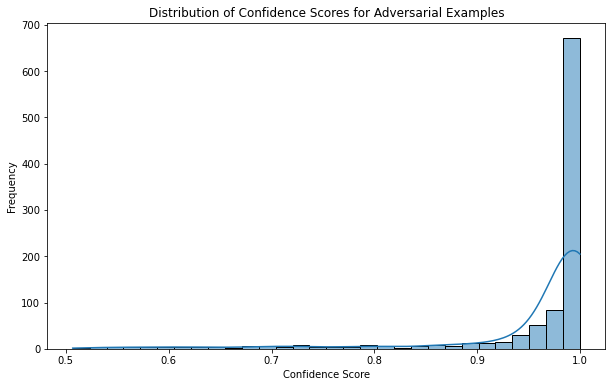

In [42]:
plot(results_df_lang)